# Data Exploration Notebook

This notebook performs an initial exploration of the 5k labeled dataset and the 2k operational dataset. The goal is to understand the structure, data quality, class distribution, and overall behavior of key operational metrics. This step establishes baseline insights and identifies potential issues before feature engineering and modeling.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

data_path = Path("../data/raw")

# Display settings for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Load and Inspect Datasets

In [2]:
# Load datasets

df_5k = pd.read_csv(data_path / "5kp.csv")
df_2k = pd.read_csv(data_path / "2k.csv")
df_activity_ref = pd.read_csv(data_path / "Activity_Reference.csv")
df_dictionary = pd.read_csv(data_path / "Event_Log_Dictionary.csv")
    

print("\nINITIAL DATASET SHAPES")

print(f"5k dataset:           {df_5k.shape[0]:,} rows × {df_5k.shape[1]} columns")
print(f"2k dataset:           {df_2k.shape[0]:,} rows × {df_2k.shape[1]} columns")
print(f"Activity Reference:   {df_activity_ref.shape[0]:,} rows × {df_activity_ref.shape[1]} columns")
print(f"Data Dictionary:      {df_dictionary.shape[0]:,} rows × {df_dictionary.shape[1]} columns\n")

# QUICK PREVIEW OF EACH DATASET

print("5K DATASET - First 3 Rows")
print(df_5k.head(3))
print("\n")

print("2K DATASET - First 3 Rows")
print(df_2k.head(3))
print("\n")

print("ACTIVITY REFERENCE TABLE")
print(df_activity_ref)
print("\n")

print("5K COLUMN NAMES")
print(df_5k.columns.tolist())
print("\n")

print("2K COLUMN NAMES")
print(df_2k.columns.tolist())
print("\n")


INITIAL DATASET SHAPES
5k dataset:           50 rows × 31 columns
2k dataset:           2,000 rows × 20 columns
Activity Reference:   8 rows × 4 columns
Data Dictionary:      30 rows × 4 columns

5K DATASET - First 3 Rows
   Unnamed: 0 case_id  event_num_in_case              activity_name  \
0           0  C00001                  1            Receive Request   
1           1  C00001                  2           Validate Request   
2           2  C00001                  3  Approve Budget (optional)   

      department resource_role      resource_id  start_timestamp_utc  \
0  Sales Support   Coordinator  Coordinator-650  2025-07-18T17:02:02   
1     Operations       Analyst      Analyst-683  2025-07-18T17:41:47   
2        Finance       Manager      Manager-581  2025-07-18T18:55:46   

     end_timestamp_utc  duration_minutes  wait_time_minutes  \
0  2025-07-18T17:12:21             10.32             182.04   
1  2025-07-18T18:13:27             31.67              29.43   
2  2025-07-18T

# Data Quality Assesment

In [3]:

def assess_data_quality(df, dataset_name):
    print(f"\nDATA QUALITY ASSESSMENT: {dataset_name}")
    
    # Basic info
    print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

    # Missing values
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Missing_Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    print(f"\nMissing Values: {missing}")

    # Duplicates
    print(f"\nDuplicate Rows")
    duplicates = df.duplicated().sum()
    print(f"Total duplicate rows: {duplicates}")
    
    # Data types
    print(f"\nData Types")
    print(df.dtypes.value_counts())
    
    return missing_df

# Assess each dataset
missing_5k = assess_data_quality(df_5k, "5K LABELED DATASET")
missing_2k = assess_data_quality(df_2k, "2K OPERATIONAL DATASET")
missing_ref = assess_data_quality(df_activity_ref, "ACTIVITY REFERENCE")


DATA QUALITY ASSESSMENT: 5K LABELED DATASET

Dataset shape: 50 rows × 31 columns

Missing Values: Unnamed: 0                   0
case_id                      0
event_num_in_case            0
activity_name                0
department                   0
resource_role                0
resource_id                  0
start_timestamp_utc          0
end_timestamp_utc            0
duration_minutes             0
wait_time_minutes            0
queue_length_at_start        0
system_load_index_0to1       0
expected_duration_minutes    0
variance_to_expected         0
is_bottleneck_event          0
inbound_channel              0
region                       0
customer_tier                0
industry                     0
company_size_bucket          0
tech_maturity_1to5           0
risk_tolerance_1to5          0
priority                     0
sla_hours                    0
sla_breached                 0
handoff_count_so_far         0
case_cycle_time_hours        0
weekday                      0
ho

# Correct Data Types

In [4]:
# Fix timestamps in 5k dataset
df_5k['start_timestamp_utc'] = pd.to_datetime(df_5k['start_timestamp_utc'])
df_5k['end_timestamp_utc'] = pd.to_datetime(df_5k['end_timestamp_utc'])

# Fix timestamps in 2k dataset
df_2k['timestamp'] = pd.to_datetime(df_2k['timestamp'])

# Check if unnamed columns exist (from CSV index)
if 'Unnamed: 0' in df_5k.columns:
    df_5k = df_5k.drop('Unnamed: 0', axis=1)

if 'Unnamed: 0' in df_2k.columns:
    df_2k = df_2k.drop('Unnamed: 0', axis=1)

# Class Distribution Analysis


Class Distribution
Normal events (0):      31 (62.0%)
Bottleneck events (1):  19 (38.0%)
Total events:           50

Bottleneck Rate: {bottleneck_rate:.1f}%


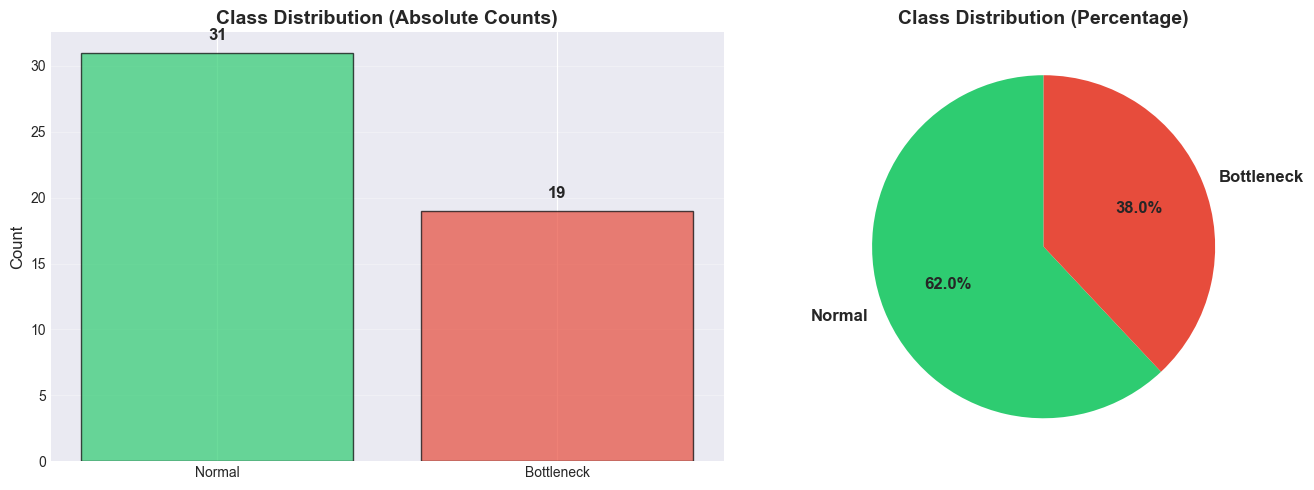


Visualization saved to: ../outputs/visualizations/class_distribution.png


In [5]:

# Count bottlenecks
class_counts = df_5k['is_bottleneck_event'].value_counts().sort_index()
class_pct = df_5k['is_bottleneck_event'].value_counts(normalize=True).sort_index() * 100

print("\nClass Distribution")
print(f"Normal events (0):     {class_counts[0]:3d} ({class_pct[0]:.1f}%)")
print(f"Bottleneck events (1): {class_counts[1]:3d} ({class_pct[1]:.1f}%)")
print(f"Total events:          {len(df_5k):3d}")

bottleneck_rate = class_pct[1]

# Assessment
print("\nBottleneck Rate: {bottleneck_rate:.1f}%")

# Visualization for Class Imbalance on 5k dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(['Normal', 'Bottleneck'], class_counts.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold', fontsize=12)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(class_counts.values, labels=['Normal', 'Bottleneck'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()

# Create directory if it doesn't exist
import os
os.makedirs('../outputs/visualizations', exist_ok=True)

plt.savefig('../outputs/visualizations/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: ../outputs/visualizations/class_distribution.png")

# EDA

In [6]:
# Separate bottleneck vs normal events
bottlenecks = df_5k[df_5k['is_bottleneck_event'] == 1].copy()
normal = df_5k[df_5k['is_bottleneck_event'] == 0].copy()

# KEY METRICS COMPARISON

print("KEY METRICS COMPARISON: Bottleneck vs Normal")

# Define metrics to compare
metrics = {
    'duration_minutes': 'Duration (minutes)',
    'wait_time_minutes': 'Wait Time (minutes)',
    'queue_length_at_start': 'Queue Length',
    'system_load_index_0to1': 'System Load (0-1)',
    'variance_to_expected': 'Variance to Expected',
    'handoff_count_so_far': 'Handoff Count'
}

comparison_results = []

for col, label in metrics.items():
    if col in df_5k.columns:
        # Calculate statistics
        bottleneck_mean = bottlenecks[col].mean()
        normal_mean = normal[col].mean()
        
        # Calculate lift (how much higher bottlenecks are)
        if normal_mean != 0:
            lift = bottleneck_mean / normal_mean
        else:
            lift = np.inf
        
        # Statistical test (t-test)
        t_stat, p_value = stats.ttest_ind(
            bottlenecks[col].dropna(), 
            normal[col].dropna()
        )
        
        significant = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        comparison_results.append({
            'Metric': label,
            'Bottleneck_Avg': bottleneck_mean,
            'Normal_Avg': normal_mean,
            'Lift': lift,
            'P_Value': p_value,
            'Significant': significant
        })
        
        print(f"\n{label}:")
        print(f"  Bottleneck avg: {bottleneck_mean:8.2f}")
        print(f"  Normal avg:     {normal_mean:8.2f}")
        print(f"  Lift:           {lift:8.2f}x {significant}")
        print(f"  P-value:        {p_value:.4f}")

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_results)

print("SUMMARY: Top Bottleneck Indicators")

print("\nMetrics ranked by lift (higher = stronger bottleneck signal):")
print(comparison_df.sort_values('Lift', ascending=False)[
    ['Metric', 'Lift', 'Significant']
].to_string(index=False))

KEY METRICS COMPARISON: Bottleneck vs Normal

Duration (minutes):
  Bottleneck avg:   116.33
  Normal avg:        56.16
  Lift:               2.07x *
  P-value:        0.0491

Wait Time (minutes):
  Bottleneck avg:    94.04
  Normal avg:        56.98
  Lift:               1.65x *
  P-value:        0.0294

Queue Length:
  Bottleneck avg:     4.95
  Normal avg:         3.39
  Lift:               1.46x **
  P-value:        0.0057

System Load (0-1):
  Bottleneck avg:     0.44
  Normal avg:         0.38
  Lift:               1.18x 
  P-value:        0.2505

Variance to Expected:
  Bottleneck avg:     0.80
  Normal avg:         0.08
  Lift:              10.02x ***
  P-value:        0.0000

Handoff Count:
  Bottleneck avg:     2.37
  Normal avg:         2.45
  Lift:               0.97x 
  P-value:        0.8641
SUMMARY: Top Bottleneck Indicators

Metrics ranked by lift (higher = stronger bottleneck signal):
              Metric      Lift Significant
Variance to Expected 10.018976         ***

# Visualization: Violin Plot

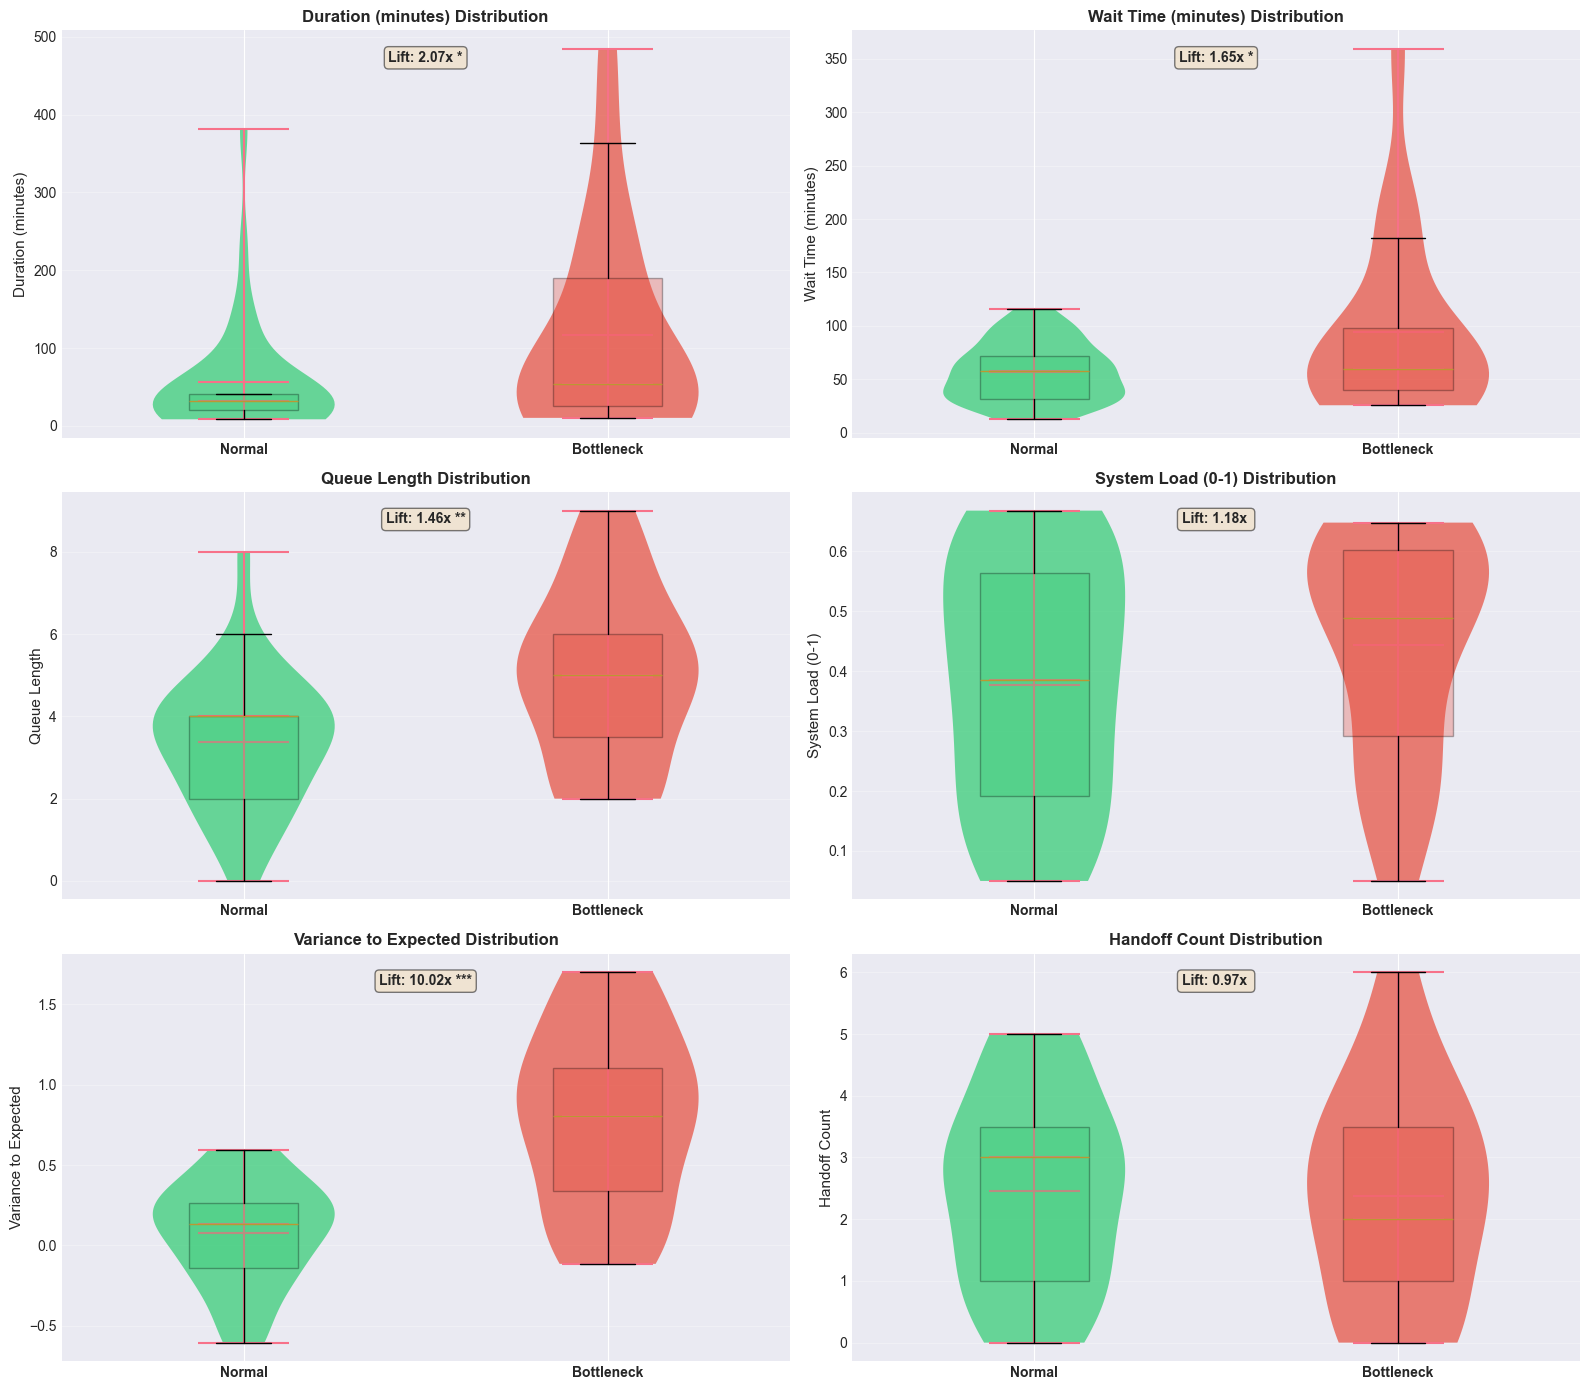

Saved to ../outputs/visualizations/feature_distributions.png


In [7]:
# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

plot_idx = 0
for col, label in metrics.items():
    if col in df_5k.columns and plot_idx < 6:
        ax = axes[plot_idx]
        
        # Violin plot
        data_to_plot = [
            normal[col].dropna(),
            bottlenecks[col].dropna()
        ]
        
        parts = ax.violinplot(
            data_to_plot,
            positions=[0, 1],
            showmeans=True,
            showmedians=True
        )
        
        # Color the violins
        for pc, color in zip(parts['bodies'], ['#2ecc71', '#e74c3c']):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
        
        # Add box plots on top
        bp = ax.boxplot(
            data_to_plot,
            positions=[0, 1],
            widths=0.3,
            patch_artist=True,
            showfliers=False
        )
        
        for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
            patch.set_facecolor(color)
            patch.set_alpha(0.3)
        
        # Labels
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Normal', 'Bottleneck'], fontweight='bold')
        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f'{label} Distribution', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add lift annotation
        lift = comparison_df[comparison_df['Metric'] == label]['Lift'].values[0]
        sig = comparison_df[comparison_df['Metric'] == label]['Significant'].values[0]
        ax.text(0.5, 0.95, f'Lift: {lift:.2f}x {sig}', 
                transform=ax.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10, fontweight='bold')
        
        plot_idx += 1

plt.tight_layout()
plt.savefig('../outputs/visualizations/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved to ../outputs/visualizations/feature_distributions.png")

# Visualization: Activity Level Bottleneck Analysis


Bottleneck Rate by Activity:
                           Bottlenecks  Total_Events  Bottleneck_Rate
activity_name                                                        
Approve Budget (optional)            3             5            0.600
Receive Request                      4             8            0.500
Execute Task                         3             7            0.429
Quality Check                        3             7            0.429
Assign Resource                      2             7            0.286
Close Ticket                         2             7            0.286
Validate Request                     2             8            0.250
Vendor Review (optional)             0             1            0.000


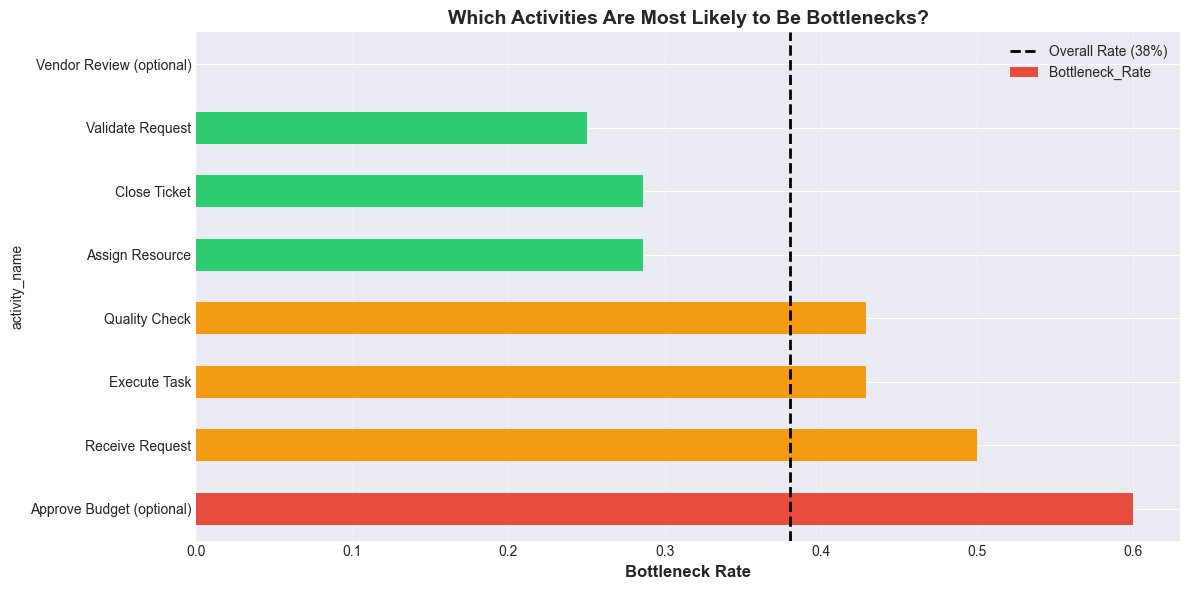

Saved to ../outputs/visualizations/activity_bottleneck_rates.png


In [8]:
activity_analysis = df_5k.groupby('activity_name').agg({
    'is_bottleneck_event': ['sum', 'count', 'mean']
}).round(3)

activity_analysis.columns = ['Bottlenecks', 'Total_Events', 'Bottleneck_Rate']
activity_analysis = activity_analysis.sort_values('Bottleneck_Rate', ascending=False)

print("\nBottleneck Rate by Activity:")
print(activity_analysis)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
activity_analysis['Bottleneck_Rate'].plot(
    kind='barh', 
    ax=ax, 
    color=['#e74c3c' if x > 0.5 else '#f39c12' if x > 0.3 else '#2ecc71' 
           for x in activity_analysis['Bottleneck_Rate']]
)
ax.set_xlabel('Bottleneck Rate', fontsize=12, fontweight='bold')
ax.set_title('Which Activities Are Most Likely to Be Bottlenecks?', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0.38, color='black', linestyle='--', linewidth=2, label='Overall Rate (38%)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/visualizations/activity_bottleneck_rates.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved to ../outputs/visualizations/activity_bottleneck_rates.png")

Temporal Bottleneck Patterns

In [9]:
# By hour of day
hour_analysis = df_5k.groupby('hour_of_day')['is_bottleneck_event'].agg(['sum', 'count', 'mean'])
hour_analysis.columns = ['Bottlenecks', 'Total', 'Rate']

print("\nBottleneck Rate by Hour of Day:")
print(hour_analysis[hour_analysis['Total'] > 0].sort_values('Rate', ascending=False).head(10))

# By weekday
weekday_analysis = df_5k.groupby('weekday')['is_bottleneck_event'].agg(['sum', 'count', 'mean'])
weekday_analysis.columns = ['Bottlenecks', 'Total', 'Rate']

print("\nBottleneck Rate by Weekday:")
print(weekday_analysis.sort_values('Rate', ascending=False))


Bottleneck Rate by Hour of Day:
             Bottlenecks  Total      Rate
hour_of_day                              
23                     2      2  1.000000
21                     1      1  1.000000
20                     4      4  1.000000
3                      2      3  0.666667
22                     1      2  0.500000
8                      1      2  0.500000
19                     1      2  0.500000
18                     1      2  0.500000
13                     2      4  0.500000
15                     1      2  0.500000

Bottleneck Rate by Weekday:
           Bottlenecks  Total      Rate
weekday                                
Monday               3      3  1.000000
Tuesday              6      9  0.666667
Wednesday            3      8  0.375000
Friday               5     15  0.333333
Saturday             1      5  0.200000
Sunday               1      6  0.166667
Thursday             0      4  0.000000


# Visualization: Correlation HeatMap

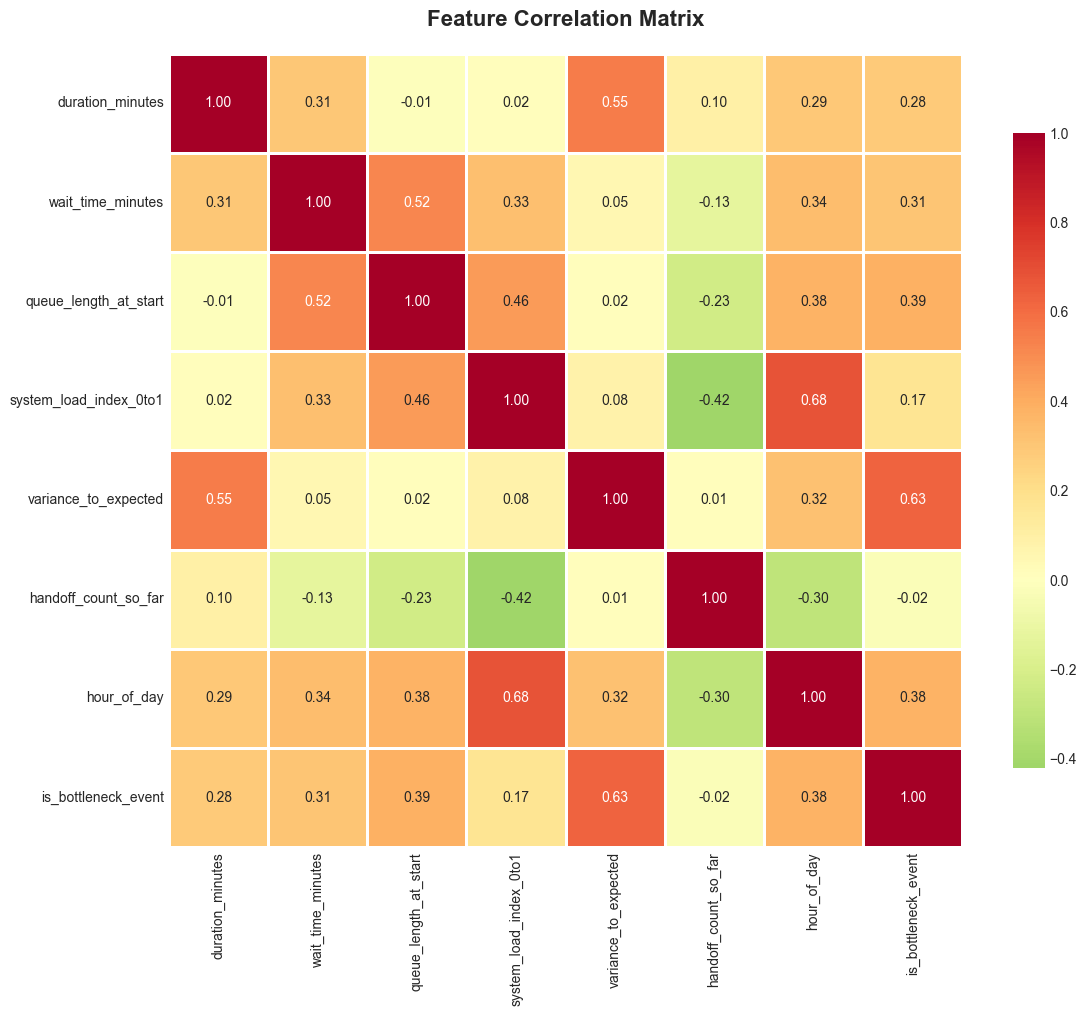

Saved: ../outputs/visualizations/correlation_heatmap.png

Correlation with Bottleneck Target:
is_bottleneck_event       1.000000
variance_to_expected      0.632950
queue_length_at_start     0.385493
hour_of_day               0.378377
wait_time_minutes         0.308276
duration_minutes          0.279721
system_load_index_0to1    0.165567
handoff_count_so_far     -0.024835


In [10]:
# Select numeric features
numeric_cols = [
    'duration_minutes', 'wait_time_minutes', 'queue_length_at_start',
    'system_load_index_0to1', 'variance_to_expected', 'handoff_count_so_far',
    'hour_of_day', 'is_bottleneck_event'
]

correlation_matrix = df_5k[numeric_cols].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='RdYlGn_r',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/visualizations/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ../outputs/visualizations/correlation_heatmap.png")

# Print correlations with target
print("\nCorrelation with Bottleneck Target:")
target_corr = correlation_matrix['is_bottleneck_event'].sort_values(ascending=False)
print(target_corr.to_string())


In [11]:
print("KEY INSIGHTS FROM EDA")

# Find top 3 predictive features
top_features = comparison_df.nlargest(3, 'Lift')

print("\nTOP 3 BOTTLENECK INDICATORS:")
for idx, row in top_features.iterrows():
    print(f"\n{idx+1}. {row['Metric']}")
    print(f"   - Bottlenecks are {row['Lift']:.2f}x higher than normal.")
    print(f"   - Statistical significance: p={row['P_Value']:.4f}")

# Most problematic activities
top_activity = activity_analysis.index[0]
top_activity_rate = activity_analysis.iloc[0]['Bottleneck_Rate']

print(f"\nMOST PROBLEMATIC ACTIVITY:")
print(f"   - '{top_activity}' has {top_activity_rate:.1%} bottleneck rate")


KEY INSIGHTS FROM EDA

TOP 3 BOTTLENECK INDICATORS:

5. Variance to Expected
   - Bottlenecks are 10.02x higher than normal.
   - Statistical significance: p=0.0000

1. Duration (minutes)
   - Bottlenecks are 2.07x higher than normal.
   - Statistical significance: p=0.0491

2. Wait Time (minutes)
   - Bottlenecks are 1.65x higher than normal.
   - Statistical significance: p=0.0294

MOST PROBLEMATIC ACTIVITY:
   - 'Approve Budget (optional)' has 60.0% bottleneck rate


In [12]:
# Save Clean Datasets to data/clean
clean_data_path = Path("../data/clean")
df_5k.to_csv(clean_data_path / "5kp_clean.csv", index=False)
df_2k.to_csv(clean_data_path / "2k_clean.csv", index=False)